In [8]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sys.path.append('../utils')
import database as db
from utils import plot_evolution

In [9]:
df = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
if not os.path.exists("fig/rq1"):
    os.makedirs("fig/rq1")

## Type of Vulnerabilities

In [11]:
df = pd.read_sql("SELECT id, package, sfp_id, published, vul_version FROM cve", con=db.conn)
temp = df["sfp_id"].apply(lambda x: len(eval(x)))
temp = temp[temp.apply(lambda x: False if x==0 else True)]
categorized_vul = df[df["sfp_id"].apply(lambda x: False if len(eval(x))==0 else True)]
print("# vulnerablities:"+str(len(df)))
print(f"# categorized vulnerabilities: {len(categorized_vul)}")
print(f"# minimum vulnerability categories: {temp.min()}")
print(f"# maximum vulnerability categories: {temp.max()}")
print(f"# median vulnerability categories: {temp.median()}")
print(f"# average vulnerability categories: {temp.sum()/len(categorized_vul)}")
print(f"std of vulnerability categories: {temp.std()}")
print()

cve_type = dict()
cve_type["non category"] = 0
men_sync_cnt = 0
mem_cnt = 0
for index, row in df.iterrows():
    categories = eval(row["sfp_id"])
    if categories!= None and len(categories):
        for cat in categories:
            if cve_type.get(cat) == None:
                cve_type[cat] = 1
            else:
                cve_type[cat] += 1
    else:
        cve_type["non category"]+=1
    if 'Memory Management' in categories or 'Memory Access' in categories or 'Synchronization' in categories:
        men_sync_cnt += 1
    if 'Memory Management' in categories or 'Memory Access' in categories:
        mem_cnt += 1
num_cateorized_vul = len(df)-cve_type["non category"]
cve_type = sorted(cve_type.items(), key=lambda kv: kv[1])
print(f"# mem_sync_vul: {men_sync_cnt} ({men_sync_cnt/num_cateorized_vul*100}%) ")
print(f"# mem_cnt: {mem_cnt} ({mem_cnt/num_cateorized_vul*100}%) ")
total = temp.sum()
# print(f"# count: {total}")
for t in cve_type:
    print(f"{t[0]:<25} {t[1]:<5} {t[1]/num_cateorized_vul*100}")

# vulnerablities:433
# categorized vulnerabilities: 360
# minimum vulnerability categories: 1
# maximum vulnerability categories: 4
# median vulnerability categories: 1.0
# average vulnerability categories: 1.65
std of vulnerability categories: 0.7609918758419784

# mem_sync_vul: 229 (63.61111111111111%) 
# mem_cnt: 215 (59.72222222222222%) 
Failure to Release Memory 1     0.2777777777777778
API                       2     0.5555555555555556
Access Control            2     0.5555555555555556
Predictability            3     0.8333333333333334
Authentication            3     0.8333333333333334
Privilege                 4     1.1111111111111112
Information Leak          9     2.5
Path Resolution           14    3.888888888888889
Risky Values              21    5.833333333333333
Cryptography              26    7.222222222222221
Other                     26    7.222222222222221
Exception Management      38    10.555555555555555
Resource Management       40    11.11111111111111
Tainted Input

###  Vulnerability life spans -- When are vulnerabilities introduced? 

r2 from 2015-07 to 2020-02: 0.9561135357646083


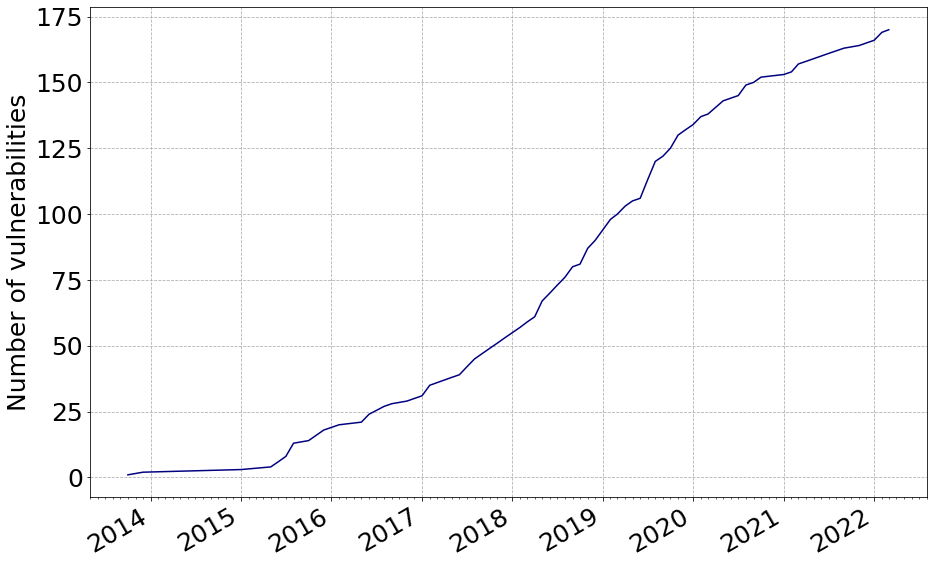

In [12]:
import ast
import datetime
import scipy.stats

df = pd.read_sql("SELECT cve_id, introduced_date FROM commit_life_spans", con=db.conn)
df_vul = pd.read_sql("SELECT id, published, sfp_id FROM cve2", con=db.conn)
df = df[df['introduced_date'].apply(lambda x: x is not None)]
# get earliest introduced date for each vulnerability
df = df.groupby(['cve_id']).min()
df = df.reset_index()
# get published date & vul types for each vulnerability
for _, row in df.iterrows():
    cve_id = row['cve_id']
    ids = list(df_vul['id'].apply(lambda x: eval(x)))
    published = None
    for id in ids:
        if cve_id in id:
            published = df_vul[df_vul['id']==str(id)]['published'].values[0]
            df.loc[df['cve_id']==cve_id, 'published'] = published
            df.loc[df['cve_id']==cve_id, 'sfp_id'] = df_vul[df_vul['id']==str(id)]['sfp_id'].values[0] 
            break

# calculate number of vulnerabilities introduced per day
introduced = df["introduced_date"]
introduced = introduced.apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x.split()[0],"%Y-%m-%d").strftime("%Y-%m")))
num_introduced_per_day = introduced.value_counts().sort_index()
num_introduced_acc = num_introduced_per_day.cumsum()
# plot the introduced vulnerabilities over time
plot_evolution(num_introduced_acc.index, num_introduced_acc.values, 'Number of vulnerabilities', 'fig/rq1/vulnerabilities_introduced_over_time.png')
# calculate R-square value
num_introduced_acc = num_introduced_acc[5:-15]
days = (num_introduced_acc.index - num_introduced_acc.index[0]).days
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(days, num_introduced_acc.values)
print(f"r2 from 2015-07 to 2020-02: {r_value**2}")


### CDF of disclosure duration

Disclosure Duration Mean=769.6586826347306
Disclosure Duration Median=693.0
Disclosure Duration Min=2
Disclosure Duration Max=2364
Disclosure Duration Std=534.2188619275979
The vulnerability with the longest disclosed duration: 
{'cve_id': 'GHSA-rwf4-gx62-rqfw', 'introduced_date': '2015-12-16 10:34:38-08:00', 'published': '2022-06-07T12:00:00Z', 'sfp_id': "['Synchronization', 'Memory Management']", 'disclosed_duration': 2364}
# the vulnerability with disclosed duration < 30: 3 (1.7964071856287425%)
average introduced date of < 30: 2021-08-26T01:45:42
average introduced date of total: 2018-09-04T19:27:06


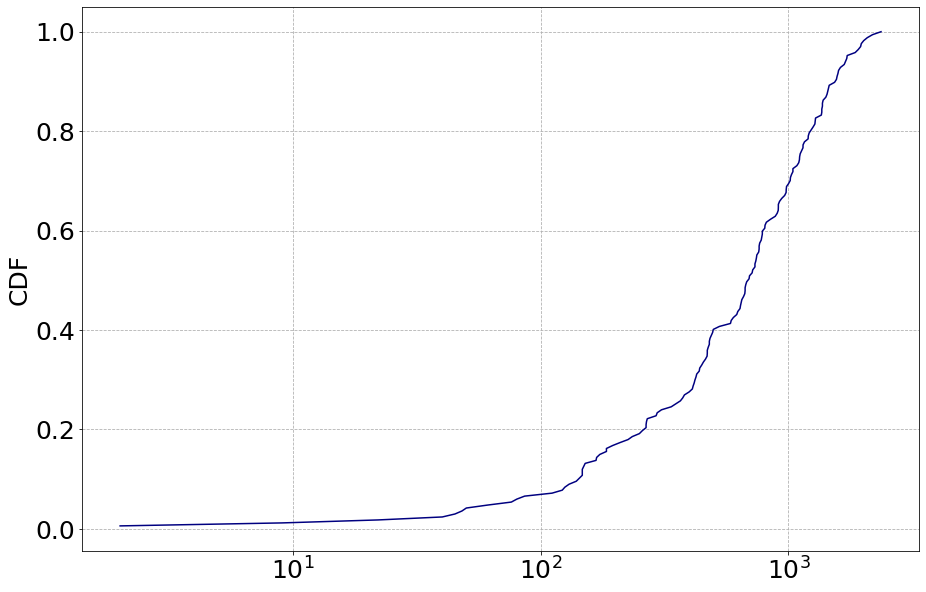

In [13]:
import numpy as np
# get time between introduced & disclosed
introduced = df['introduced_date'].apply(lambda x: pd.to_datetime(x, utc=True))
published = df['published'].apply(lambda x: pd.to_datetime(x, utc=True))
df['disclosed_duration'] = (published - introduced).dt.days

df = df[df['disclosed_duration'] > 0]
days = df['disclosed_duration']
print(f"Disclosure Duration Mean={days.mean()}")
print(f"Disclosure Duration Median={days.median()}")
print(f"Disclosure Duration Min={days.min()}")
print(f"Disclosure Duration Max={days.max()}")
print(f"Disclosure Duration Std={days.std()}")
print("="*20)

# check statistics of disclosed duration
longest = df[df['disclosed_duration']==df['disclosed_duration'].max()]
print("The vulnerability with the longest disclosed duration: ")
print(longest.to_dict('records')[0])
#  disclosure duration less than 30 day
temp = df[df['disclosed_duration']<30]
print(f"# the vulnerability with disclosed duration < 30: {len(temp)} ({len(temp)/len(df)*100}%)")
mean_temp = (np.array(temp['introduced_date'], dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
mean_df = (np.array(df['introduced_date'], dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
print(f"average introduced date of < 30: {mean_temp}")
print(f"average introduced date of total: {mean_df}")

# plot CDF of disclosure duration
import numpy as np
days = np.array(list(df['disclosed_duration']))
# compute the CDF
cdfx = np.sort(days)
cdfy = np.linspace(1 / len(days), 1.0, len(days))
# plot the CDF
plot_evolution(cdfx, cdfy, 'CDF', 'fig/rq1/vulnerabilities_disclosure_duration.png', evol=False, xlog=True)

### Disclosure duration across vul types

In [14]:
from scipy.stats import ranksums
interest_cats = ['Memory Management', 'Memory Access' , 'Synchronization', 'Tainted Input', 'Resource Management', 'Exception Management', 'Cryptography',\
                 'Other', 'Risky Values', 'Path Resolution', 'Information Leak', 'Privilege', 'Predictability', 'Authentication', 'API', 'Access Control', 'Failure to Release Memory']
frequent_cats = ['Memory Management', 'Memory Access' , 'Synchronization', 'Tainted Input', 'Resource Management', 'Exception Management', 'Cryptography',\
                    'Other', 'Risky Values']
rare_cats = ['Path Resolution', 'Information Leak', 'Privilege', 'Predictability', 'Authentication', 'API', 'Access Control', 'Failure to Release Memory']
frequent_durations = []
rare_durations = []
for cat in interest_cats:
    temp = df[df['sfp_id'].apply(lambda x: True if cat in x else False)]
    days = temp['disclosed_duration']
    if cat in frequent_cats:
        frequent_durations.append(days.median())
    elif cat in rare_cats:
        rare_durations.append(days.median())
    print(f"{cat}: {days.median()} {len(days)}")

# Wilcoxon rank-sum tests
print(ranksums(frequent_durations, rare_durations, alternative='greater', nan_policy='omit'))

Memory Management: 668.0 67
Memory Access: 678.0 53
Synchronization: 770.5 44
Tainted Input: 780.0 23
Resource Management: 599.0 37
Exception Management: 1062.5 18
Cryptography: 757.5 8
Other: 419.5 10
Risky Values: 802.0 10
Path Resolution: 165.5 12
Information Leak: 80.0 3
Privilege: 76.0 1
Predictability: 107.5 2
Authentication: nan 0
API: 846.0 1
Access Control: nan 0
Failure to Release Memory: nan 0
RanksumsResult(statistic=1.9333333333333333, pvalue=0.026597574021009627)


###  Vulnerability life spans --  When are vulnerabilities fixed? 

In [15]:
df = pd.read_sql("SELECT cve_id, fix_date FROM commit_life_spans", con=db.conn)
df_vul = pd.read_sql("SELECT id, published, sfp_id FROM cve2", con=db.conn)
df = df[df['fix_date'].apply(lambda x: x is not None)]
# get latest fix date for each vulnerability
df = df.groupby(['cve_id']).max()
df = df.reset_index()
# get published date for each vulnerability
for _, row in df.iterrows():
    cve_id = row['cve_id']
    ids = list(df_vul['id'].apply(lambda x: eval(x)))
    published = None
    for id in ids:
        if cve_id in id:
            published = df_vul[df_vul['id']==str(id)]['published'].values[0]
            df.loc[df['cve_id']==cve_id, 'published'] = published
            df.loc[df['cve_id']==cve_id, 'sfp_id'] = df_vul[df_vul['id']==str(id)]['sfp_id'].values[0] 
            break

# get time between disclosed & fixed
fixed = df['fix_date'].apply(lambda x: pd.to_datetime(x, utc=True))
published = df['published'].apply(lambda x: pd.to_datetime(x, utc=True))
df['fix_duration'] = (fixed-published).dt.days
print(f"# fixed before disclosure: {len(df[df['fix_duration'] <= 0])}")
print(f"# fixed after disclosure: {len(df[df['fix_duration'] > 0])}")
days = df['fix_duration']
# print(df[df['disclosed_duration']>2500])
print(f"Fix Duration Mean={days.mean()}")
print(f"Fix Duration Median={days.median()}")
print(f"Fix Duration Min={days.min()}")
print(f"Fix Duration Max={days.max()}")
print(f"Fix Duration Std={days.std()}")

# fixed before disclosure: 120
# fixed after disclosure: 60
Fix Duration Mean=-5.4
Fix Duration Median=0.0
Fix Duration Min=-1986
Fix Duration Max=686
Fix Duration Std=198.52645996758864


### CDFs of fix duration

                 cve_id                   fix_date             published  \
76  GHSA-mcrf-7hf9-f6q5  2019-10-08 18:33:23+02:00  2017-11-21T12:00:00Z   

                     sfp_id  fix_duration  
76  ['Resource Management']           686  
Fix Duration Mean after disclosure=88.15
Fix Duration Median after disclosure=23.5
Fix Duration Min after disclosure=1
Fix Duration Max after disclosure=686
Fix Duration Std after disclosure=146.03770409366604


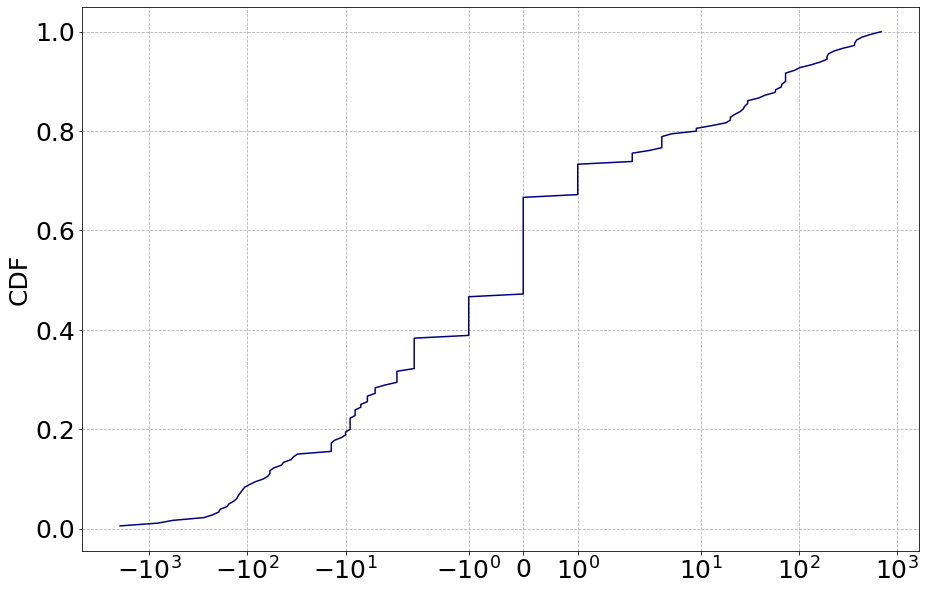

In [16]:
# plot CDF of fix duration
import numpy as np
days = np.array(list(df['fix_duration']))
# compute the CDF
cdfx = np.sort(days)
cdfy = np.linspace(1 / len(days), 1.0, len(days))
# plot the CDF
plot_evolution(cdfx, cdfy, 'CDF', 'fig/rq1/vulnerabilities_fix_duration.png', evol=False, xlog=True)

print((df[df['fix_duration']>680]))
days = df[df['fix_duration']>0]['fix_duration']
print(f"Fix Duration Mean after disclosure={days.mean()}")
print(f"Fix Duration Median after disclosure={days.median()}")
print(f"Fix Duration Min after disclosure={days.min()}")
print(f"Fix Duration Max after disclosure={days.max()}")
print(f"Fix Duration Std after disclosure={days.std()}")

### Fix duration across vul types

In [17]:
interest_cats = ['Memory Management', 'Memory Access' , 'Synchronization', 'Tainted Input', 'Resource Management', 'Exception Management', 'Cryptography',\
                 'Other', 'Risky Values', 'Path Resolution', 'Information Leak', 'Privilege', 'Predictability', 'Authentication', 'API', 'Access Control', 'Failure to Release Memory']
for cat in interest_cats:
    temp = df[df['sfp_id'].apply(lambda x: True if cat in x else False)]
    days = temp['fix_duration']
    # days = (days[days > 1])
    print(f"{cat}: {days.median()}")

Memory Management: 1.0
Memory Access: 0.0
Synchronization: 0.0
Tainted Input: -5.0
Resource Management: -2.0
Exception Management: 18.0
Cryptography: -2.0
Other: -1.0
Risky Values: -2.0
Path Resolution: -2.0
Information Leak: -14.0
Privilege: -5.0
Predictability: -2.0
Authentication: nan
API: 30.0
Access Control: nan
Failure to Release Memory: nan


## Evolution of Vulnerabilities--All

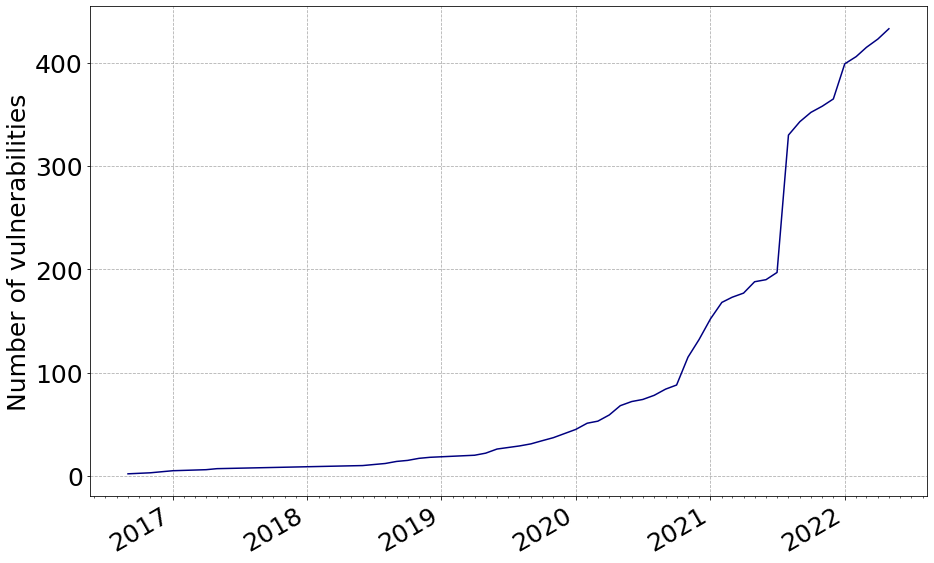

In [18]:
import datetime
df = pd.read_sql("SELECT id, package, sfp_id, published, severity FROM cve", con=db.conn)
published = df["published"]
published = published.apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")))
num_published_per_day = published.value_counts().sort_index()
num_created_acc = num_published_per_day.cumsum()
# print(num_created_acc)
plot_evolution(num_created_acc.index, num_created_acc.values, 'Number of vulnerabilities', 'fig/rq1/vulnerabilities_over_time.png')

### Evolution of Vulnerabilities--across vulnerability type

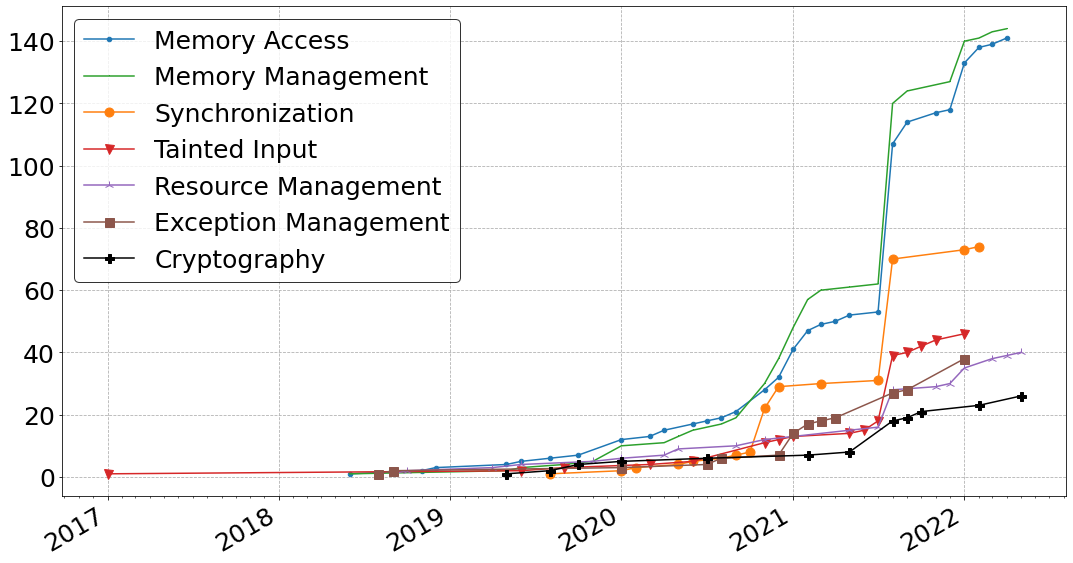

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_sql("SELECT id, package, sfp_id, published, severity FROM cve", con=db.conn)
interest_cats = ['Memory Access', 'Memory Management', 'Synchronization', 'Tainted Input', 'Resource Management', 'Exception Management', 'Cryptography']
color_list = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'black', 'salmon', 'navy', 'olive']

plt.style.use('seaborn-colorblind') 
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.tick_params(labelsize=25)
ax.yaxis.label.set_size(25)
ax.title.set_size(20)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
fig.autofmt_xdate()

ax.grid(True, linestyle='--', which="major")
markers = '.,ov2sP*|d+x'
i=0
for cat in interest_cats:
    temp = df[df['sfp_id'].apply(lambda x: True if cat in x else False)]
    published = temp["published"]
    published = published.apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")))
    num_published_per_day = published.value_counts().sort_index()
    num_created_acc = num_published_per_day.cumsum()
    ax.plot(num_created_acc.index, num_created_acc.values,color=color_list[i%10], label=cat, markersize=9, marker=markers[i%10])
    i = i+1
    # if cat =='Exception Management':
    #     print(num_created_acc)
    
legend = ax.legend(framealpha=1)
plt.legend(loc=2, prop={'size': 25},frameon = 1, facecolor = 'white', edgecolor = 'black') 
fig.savefig('fig/rq1/vul_overtime_across_type.png', facecolor='white', dpi=200) 

### Rate of reported vulnerabilities per 1,000 packages

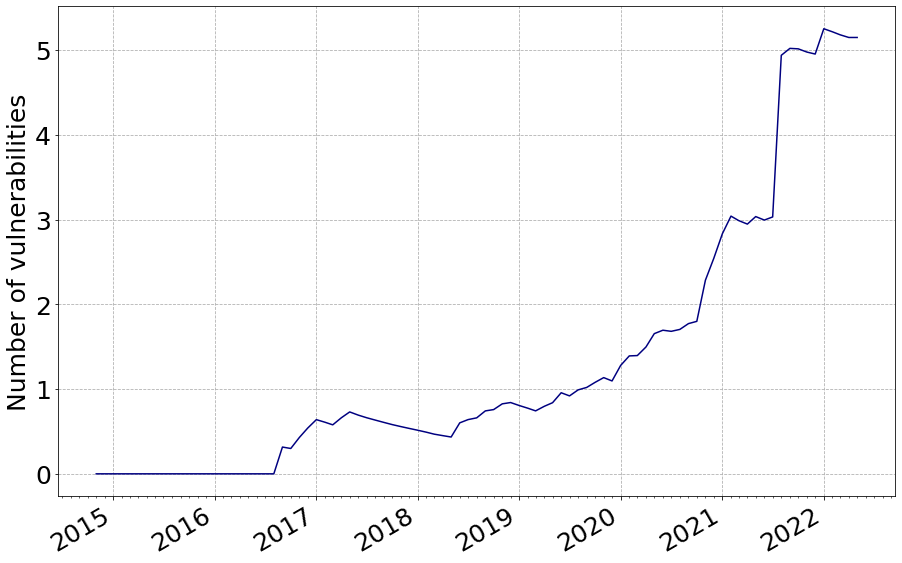

In [20]:
def get_vul_rate(num_created_acc, num_published_acc):
    res = list()
    ind2 = 0
    for i in range(len(num_created_acc)):
        if ind2 >=len(num_published_acc):
            res.append(res[i-1])
        else:
            if num_created_acc.index[i] == num_published_acc.index[ind2]:
                res.append(num_published_acc[ind2])
                ind2+=1
            else:
                res.append( 0 if ind2==0 else res[i-1])
    for i in range(len(res)):
        res[i] = res[i]/(num_created_acc[i]/1000)
    return res

df = pd.read_sql("SELECT * FROM crates", con=db.conn)
temp = df["created_at"]
temp = temp.apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x.split()[0],"%Y-%m-%d").strftime("%Y-%m")))
num_created_per_day = temp.value_counts().sort_index()
num_created_acc = num_created_per_day.cumsum()

df = pd.read_sql("SELECT id, package, published FROM cve", con=db.conn)
temp = df["published"]
temp = temp.apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")))
num_published_per_day = temp.value_counts().sort_index()
num_published_acc = num_published_per_day.cumsum()
res = get_vul_rate(num_created_acc, num_published_acc)

plot_evolution(num_created_acc.index, res, 'Number of vulnerabilities', 'fig/rq1/vulnerabilities_crates_over_time.png')

### Number of published vulnerabilities normalized to LOC vulnerable package

In [21]:
import ast
from packaging.version import Version

def get_affect_loc(package, vul_version):
  cur = db.conn.cursor()
  cur.execute(f"SELECT num, crate_size from versions where\
                crate_id = (SELECT id from crates where name=\'{package}\')")
  results = cur.fetchall()
  tmp = list()
  if len(results) == 0:
    return 0
  for res in results:
    try:
      tmp.append((Version(res[0]), res[1]))
    except:
      continue
  results = tmp
  results = sorted(results, key=lambda kv: kv[0])
  # find latest affected version
  vul_versions = ast.literal_eval(str(vul_version))
  affected = []
  if len(vul_versions) == 0:
    affected.append(results[-1][0])
  for v in vul_versions:
    if v[1] is None:
      affected.append(results[-1][0])
    else:
      affected.append(Version(v[1]))
  assert len(affected) > 0
  affected = sorted(affected)[-1]
  
  for r in results:
    if r[0] == affected:
      return float(r[1]) if r[1] is not None else 0
  return 0
  
df = pd.read_sql("SELECT id, package, vul_version, published FROM cve", con=db.conn)
df['lines'] = df.apply(lambda x: get_affect_loc(x.package, x.vul_version), axis=1)
df = df[df['lines']>0]


df["published"] = df["published"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")) 
packages = list()
def get_loc(lines, package):
  res = lines if package not in packages else 0
  packages.append(package)
  return res
lines = df.apply(lambda x: get_loc(x.lines, x.package), axis=1)
df_temp = pd.DataFrame()
df_temp['lines'] = lines
df_temp["created_month"] = df["published"] 
temp = df_temp.groupby(['created_month']).sum()
num_loc_acc = temp.cumsum()

num_published_per_day = df["published"].value_counts().sort_index()
num_published_acc = num_published_per_day.cumsum()


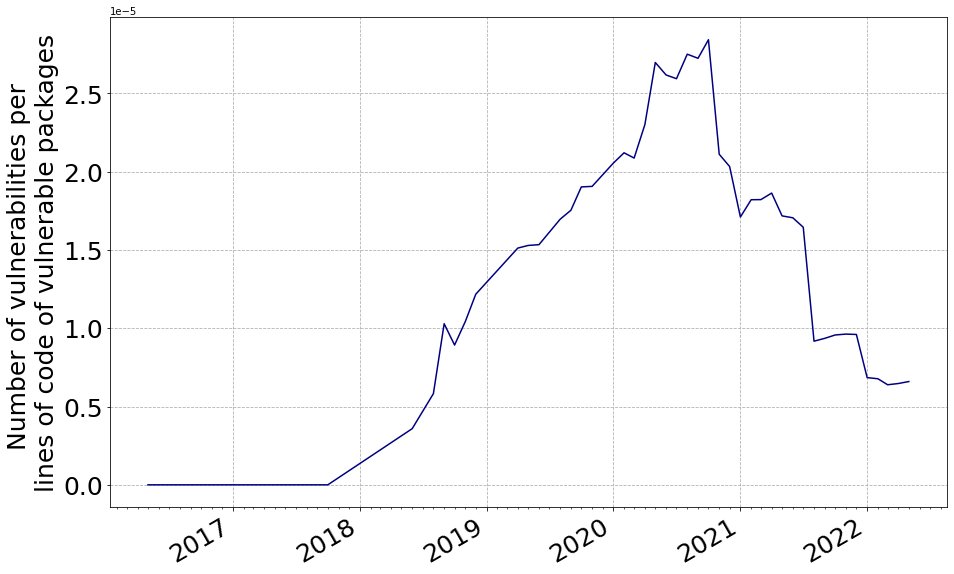

In [22]:
t = pd.concat([num_published_acc, num_loc_acc], axis=1)
t.rename(columns={'count': 'published'}, inplace = True)
t = t.filter(['published', 'lines'], axis=1)
t_index = list(t.index)
t['normalized'] = t.apply(lambda x: x.published/x.lines, axis=1)
temp = pd.date_range('2016-05-01','2017-10-01', 
              freq='MS').strftime("%Y-%m").tolist()

df_temp = pd.DataFrame(index=temp)
df_temp["published"] = 0
df_temp['lines'] = 0
df_temp['normalized'] = 0
df_temp = pd.concat([df_temp, t], ignore_index=True)
temp.extend(t_index)
#
df_temp['date'] = [pd.to_datetime(d) for d in temp]
t = df_temp
t = t.set_index('date')
plot_evolution(t.index, t.normalized, 'Number of vulnerabilities per \nlines of code of vulnerable packages', 'fig/rq1/vulnerabilities_norm_loc.png')


## Evolution of Vulnerabilities--across package categories

<Figure size 2592x2880 with 0 Axes>

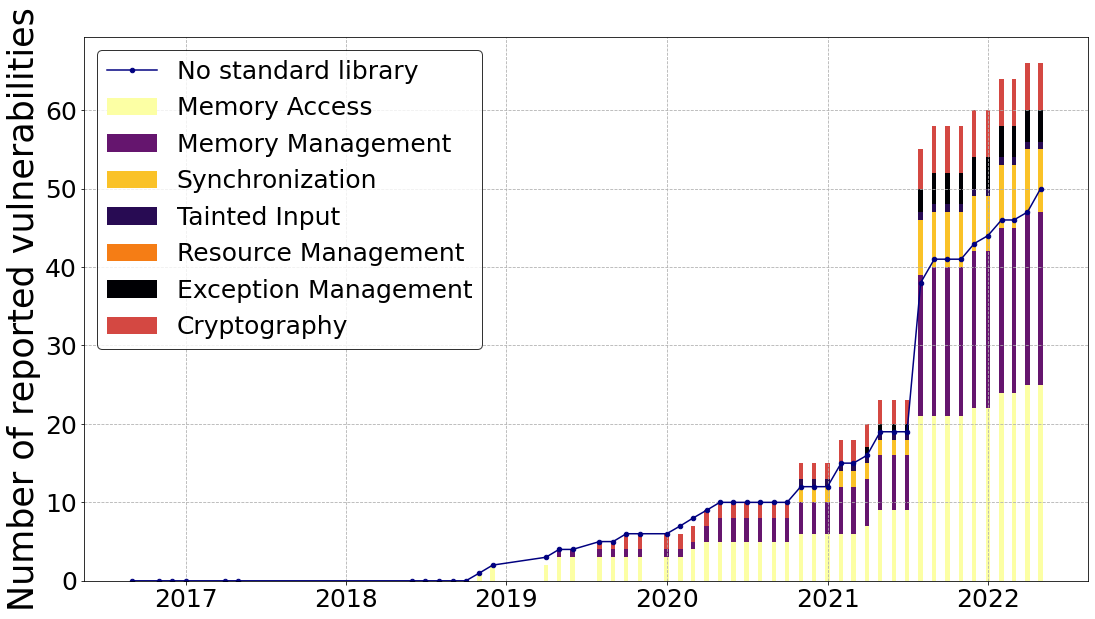

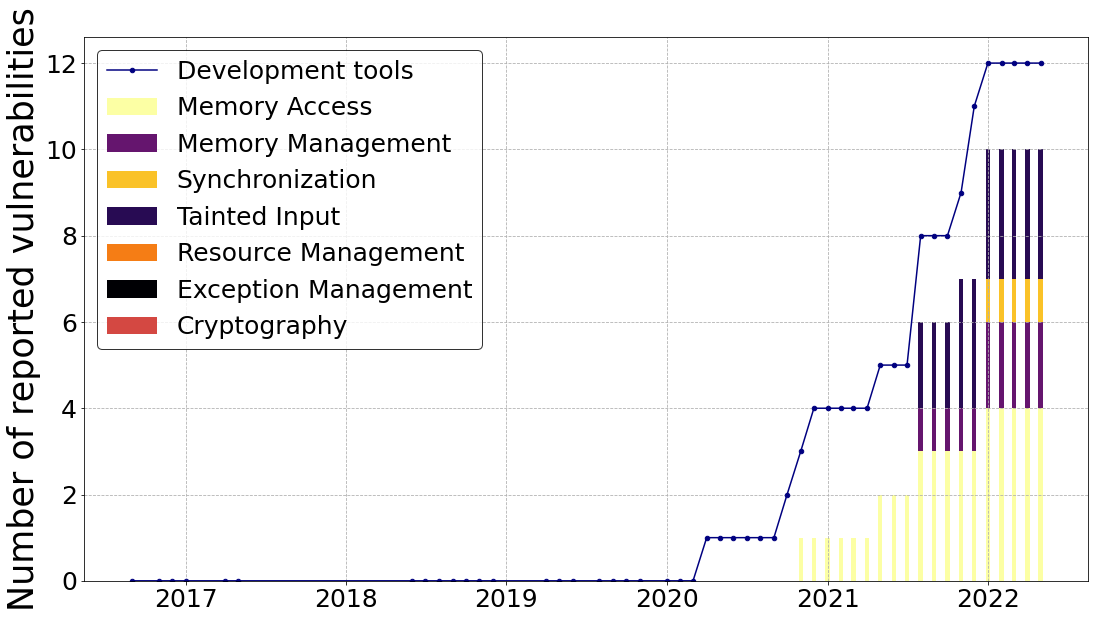

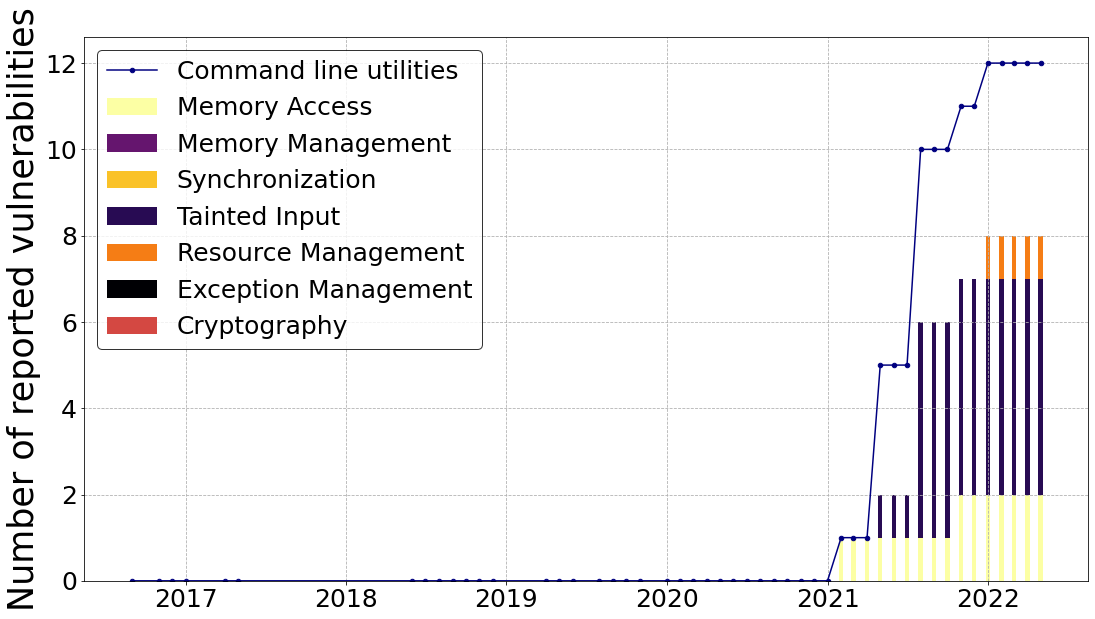

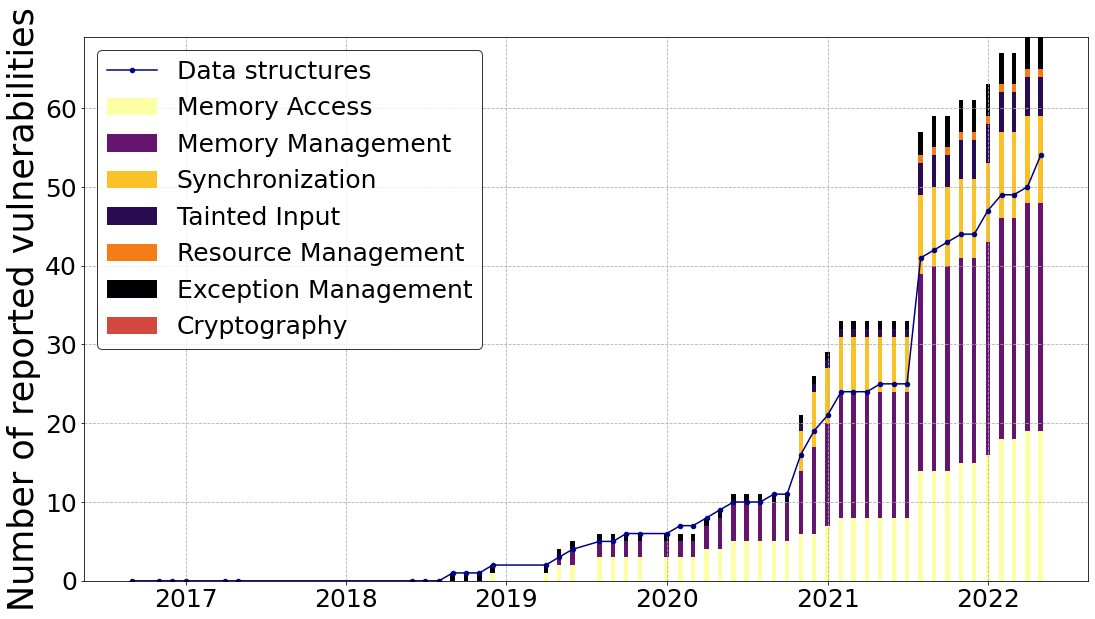

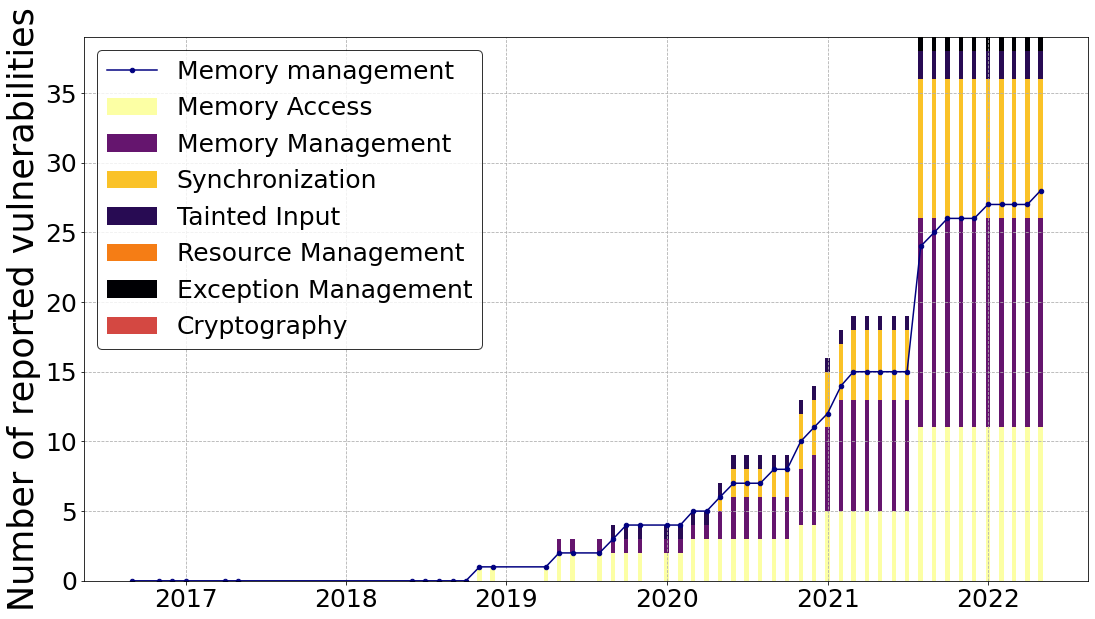

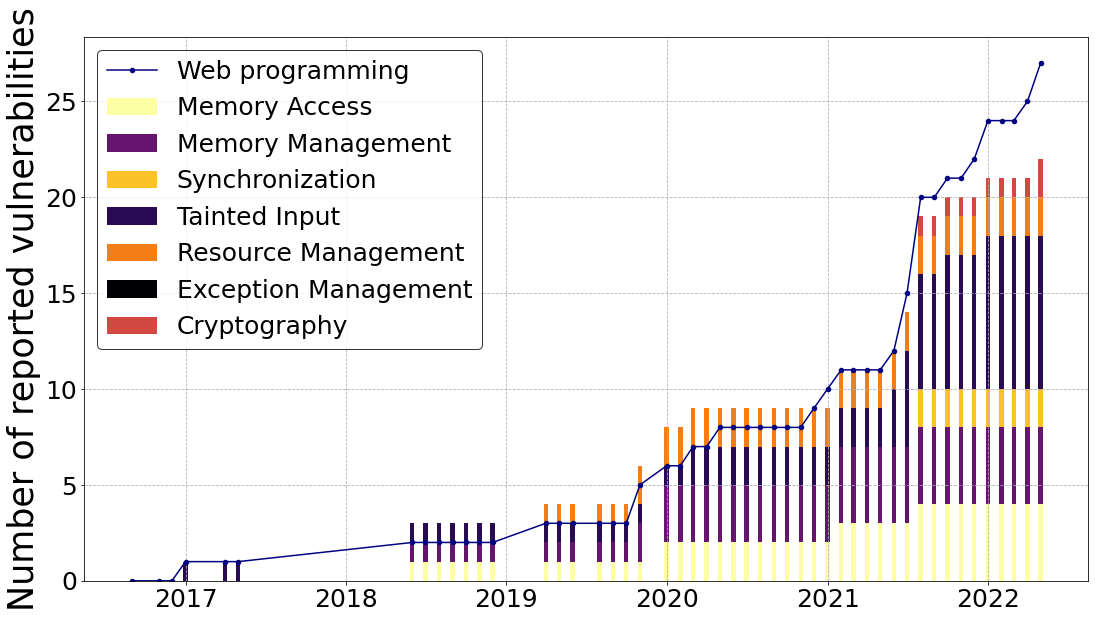

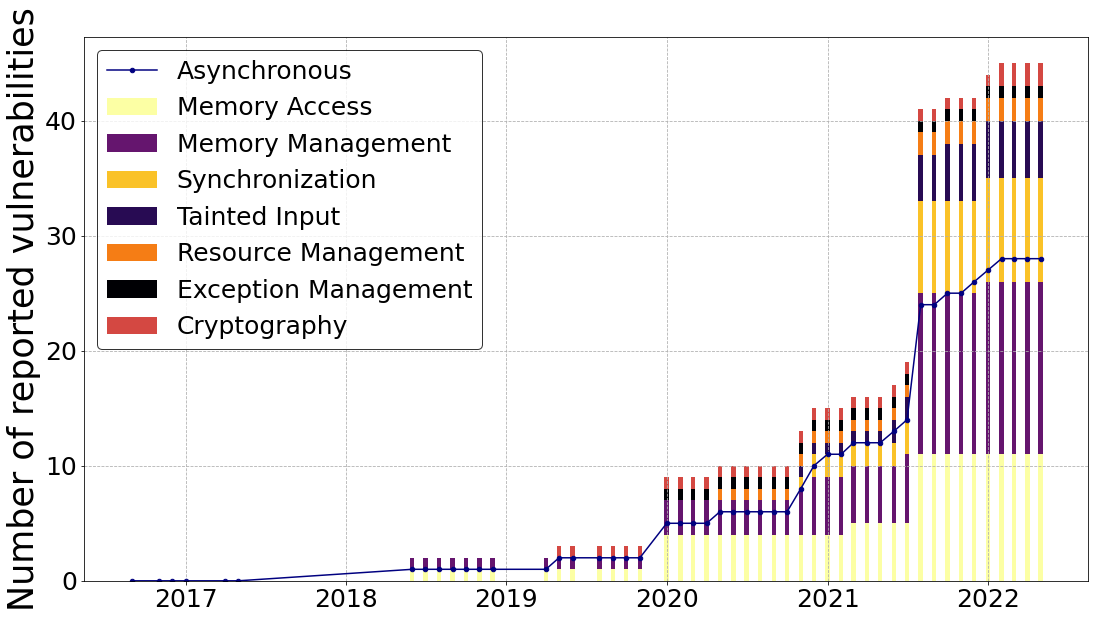

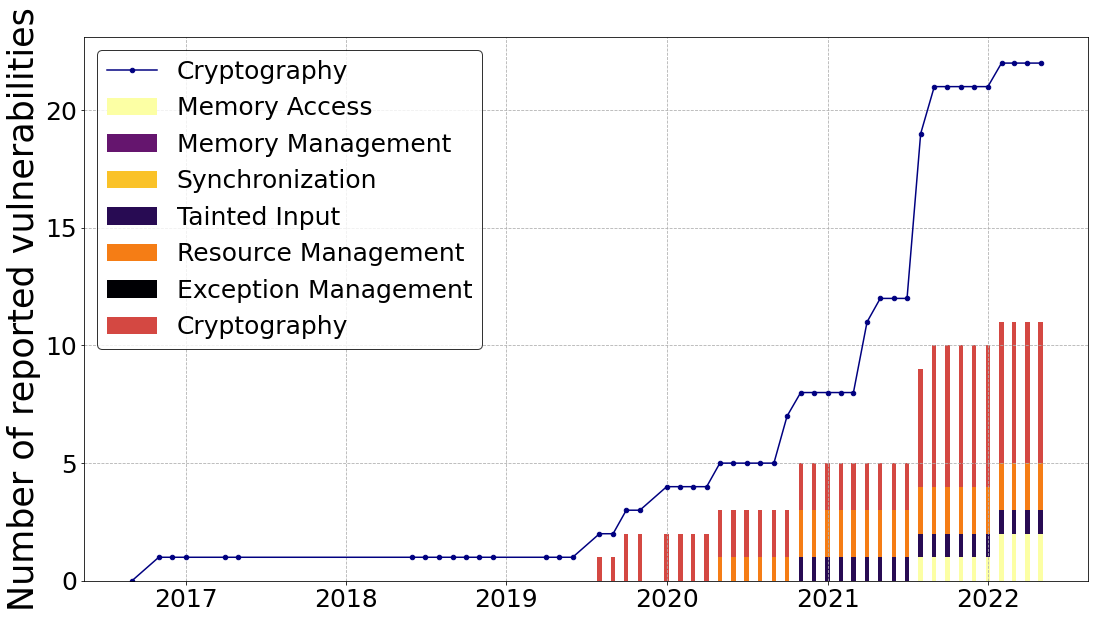

In [23]:
import datetime
df = pd.read_sql("SELECT id, package, sfp_id, published, severity FROM cve", con=db.conn)
vul_cat = list()
markers = '.,ov2sP*|d+x'
for index, row in df.iterrows():
    package = row["package"]
    cur = db.conn.cursor()
    cur.execute("SELECT category from categories where id in (\
                SELECT category_id from crates_categories where\
                crate_id = (SELECT id from crates where name=\'"+package+"\'))")
    results = cur.fetchall()
    categories = list()
#     if len(results)==0:
#         categories["no categories"] += 1
    for res in results:
        res = res[0]
        words = res.split("::")
        categories.append(words[0])
    vul_cat.append(categories)
df['category'] = vul_cat

interest_cats = ['No standard library', 'Development tools', 'Command line utilities',\
               'Data structures', 'Memory management', 'Web programming', \
               'Asynchronous', 'Cryptography']
interest_types = ['Memory Access', 'Memory Management', 'Synchronization', 'Tainted Input', 'Resource Management', 'Exception Management', 'Cryptography']
# color_list = ['#3682be','#45a776','#f05326','#eed777','#334f65','#b3974e','#38cb7d','#ddae33','#844bb3','#93c555','#5f6694','#df3881']
# color_list = cm.get_cmap('viridis', 12)(range(12))
color_list = ['#fcffa4', '#65156e', '#fac228', '#280b53','#f57d15', '#000004', '#d44842','#9f2a63']

plt.style.use('seaborn-colorblind') # 设置画图的风格 
plt.figure(figsize=(36, 40))

def format_time(num_created_acc, num_created_acc_ty):
    num_acc_ty = pd.Series(dtype=float)
    k = 0
    value = 0
    for month in num_created_acc.index:
        if k >= len(num_created_acc_ty):
            num_acc_ty = num_acc_ty.append(pd.Series([value], index=[month]))
        elif month < num_created_acc_ty.index[k]:
            num_acc_ty = num_acc_ty.append(pd.Series([value], index=[month]))
        elif month == num_created_acc_ty.index[k]:
            value = num_created_acc_ty.values[k]
            num_acc_ty = num_acc_ty.append(pd.Series([value], index=[month]))
            k += 1
    return num_acc_ty

i=0
published = df["published"]
published = published.apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")))
num_published_per_day = published.value_counts().sort_index()
num_created_acc_total = num_published_per_day.cumsum()
for cat in interest_cats:
    df_cat = df[df['category'].apply(lambda x: True if cat in x else False)]
    published = df_cat["published"]
    published = published.apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")))
    num_published_per_day = published.value_counts().sort_index()
    num_created_acc = num_published_per_day.cumsum()
    num_created_acc = format_time(num_created_acc_total, num_created_acc)
    # ax = plt.subplot(4, 2, i + 1)
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    ax.tick_params(labelsize=25)
    ax.yaxis.label.set_size(35)
    ax.title.set_size(20)
    ax.set(ylabel='Number of reported vulnerabilities')
    # ax.set_title(f"Distribution of vulnerabilities types in {cat}", fontsize=30, pad=10)

    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    # ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # fig.autofmt_xdate()

    ax.grid(True, linestyle='--', which="major")
    ax.plot(num_created_acc.index, num_created_acc.values,color='navy', label=cat,markersize=9, marker='.')
    cnt = None
    j = 0
    for ty in interest_types:
        temp = df_cat[df_cat['sfp_id'].apply(lambda x: True if ty in x else False)]
        published_ty = temp["published"]
        published_ty = published_ty.apply(lambda x: pd.to_datetime(datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")))
        num_published_per_day_ty = published_ty.value_counts().sort_index()
        num_created_acc_ty = num_published_per_day_ty.cumsum()
        num_acc_ty = format_time(num_created_acc, num_created_acc_ty)
        if cnt is None:
            ax.bar(num_acc_ty.index, num_acc_ty.values, width = 10, color=color_list[j%10], label=ty)
            cnt = num_acc_ty.values 
        else:
            ax.bar(num_acc_ty.index, num_acc_ty.values, bottom=cnt, width = 10, color=color_list[j%10], label=ty)
            for index, value in enumerate(cnt):
                cnt[index] = cnt[index] + num_acc_ty.values[index]
        
        j+= 1
    legend = ax.legend(framealpha=1)
    plt.legend(loc=2, prop={'size': 25},frameon = 1, facecolor = 'white', edgecolor = 'black') 
    plt.savefig(f'fig/rq1/vul_package_{cat}.png', facecolor='white')
    i = i+1
    
